# Training a character language model and studying various ways of generating text

**Author: matthieu.labeau@telecom-paris.fr**

## Objectives:

- We will train a network to predict a next character given an input sequence of characters, and use it to generate new sequences.
    - We will strictly work with local (and not structured) prediction - however, we will look into relatively simple heuristics to improve the "structure" of our generation: *temperature* sampling, *beam search*, *top-k* sampling, *top-p* sampling, drop-out input data.
    - We will use ```keras```to build the model based on a LSTM, which will use simple features (one-hot vector representing previous characters) to predict the next characters. We will use a small model to avoid training for too long.
    - We will use a small dataset (poetry, from project Gutenberg) - you can use any data you prefer, as long as you are able to train the model on it.
    - Even with a small dataset and a small model, training may be long (~1 min/epoch on GPU). If you can use a computing infrastructure, like Google colab, it may be more practical - and you probably can obtain better results by using a bigger model and a larger dataset.  
- We will look into extending our model with embeddings and *stateful LSTMs*.
- We will try on a modern model available online.

In [1]:
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

### Obtaining the data
- We download directly the ebook from project Gutenberg - you can get any other text you would prefer.

In [2]:
from keras.utils import get_file
url = 'https://www.gutenberg.org/cache/epub/100/pg100.txt'
path = get_file('pg100.txt', origin=url)

f = open(path, 'r' , encoding = 'utf8')
lines = f.readlines()
text = []

start = False
for line in lines:
    line = line.strip().lower() # Remove blanks and capitals
    if("*** START OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***".lower() in line and start==False):
        start = True
    if("*** END OF THE PROJECT GUTENBERG EBOOK THE COMPLETE WORKS OF WILLIAM SHAKESPEARE ***".lower() in line):
        break
    if(start==False or len(line) == 0):
        continue
    text.append(line)

f.close()
text = " ".join(text)
voc_chars = sorted(set([c for c in text]))
nb_chars = len(voc_chars)

5638519/5638519 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
print(lines[0])

﻿The Project Gutenberg eBook of The Complete Works of William Shakespeare



### Keeping track of possible characters
- Using a ```set```, create a sorted list of possible characters
- Create two dictionnaries, having characters and corresponding indexes as {key: value}, and reverse.

Example:

```python
chars = [a, b, c]
```

```python
chars_indices = {a: 0, b: 1, c: 2}
```

```python
indices_chars = {0: a, 1: b, 2: c}
```

<div class='alert alert-block alert-info'>
            Code:</div>

In [4]:
print('Corpus length:', len(text))

chars = set(text)
print('Total number of characters:', len(chars))
char_indices = {char:i for i,char in enumerate(chars)}
indices_char = {v:k for k,v in char_indices.items()}

Corpus length: 5300276
Total number of characters: 70


#### Parenthesis: looking at words

- Try to look at tokenization schemes: what are the most frequent words if we use *whitespace* tokenization ?

Ans: The most frequent tokens are 'the', 'and', 'i'.

- What are the most frequent words in this dataset using smarter tokenization ? You can a tokenizer from NLTK: ```nltk.word tokenize```.

Ans: Here the most frequent are punctuation like '.' and ','.

- Make a plot of rank vs. word count. Does Zipf's Law seem to hold ?

Ans: Yeah Zipf's Law obviously hold in this corpus as the word's rank is inversely proportional to the word frequency

- Do the same with characters. What do you observe ?

Ans: Zipf's Law still hold but the relationship is more linear than with words

<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
from collections import Counter
# Apply whitespace tokenization
tokens = text.split(' ')

# Get frequencies and sort words according to them
freq = Counter(tokens)
ordered_word_list = sorted(freq.items(), key=lambda x:x[1], reverse=True)
print(ordered_word_list[:100])

del tokens
del freq
del ordered_word_list

[('the', 30240), ('and', 27760), ('i', 20718), ('to', 20393), ('of', 18568), ('a', 16156), ('my', 13154), ('in', 12070), ('that', 11165), ('you', 11124), ('is', 9244), ('with', 8443), ('not', 7897), ('for', 7896), ('his', 7482), ('your', 7047), ('be', 6896), ('he', 6481), ('but', 6370), ('this', 6319), ('it', 6234), ('as', 6113), ('have', 6035), ('thou', 5489), ('me', 5113), ('will', 4783), ('thy', 4348), ('so', 4203), ('what', 4115), ('by', 3944), ('if', 3735), ('shall', 3726), ('her', 3667), ('all', 3631), ('do', 3528), ('are', 3508), ('we', 3448), ('him', 3308), ('our', 3287), ('no', 3085), ('on', 2909), ('from', 2885), ('', 2709), ('good', 2694), ('at', 2664), ('they', 2597), ('or', 2556), ('she', 2533), ('would', 2424), ('their', 2372), ('which', 2361), ('enter', 2351), ('was', 2308), ('let', 2210), ('am', 2169), ('when', 2161), ('how', 2161), ('hath', 2023), ('than', 2009), ('more', 2008), ('thee', 1928), ('i’ll', 1885), ('an', 1883), ('like', 1878), ('king', 1836), ('upon', 1791

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
from nltk import word_tokenize
tokens = word_tokenize(text)
#tokens = list(text)

freq = Counter(tokens)
ordered_word_list = sorted(freq.items(), key=lambda x:x[1], reverse=True)
print(ordered_word_list[:20])

[(',', 94577), ('.', 85824), ('the', 30301), ('and', 28420), ('’', 26338), ('i', 23597), ('to', 20715), ('of', 18743), ('a', 16245), ('you', 14587), ('my', 13182), (';', 12920), ('in', 12470), ('that', 12220), ('?', 11396), ('is', 9905), ('not', 9866), ('s', 8594), ('with', 8511), ('me', 8239)]


In [16]:
# Create an array containing the word rank in the first dimension, and its count in the second.
rank_counts = np.zeros((len(ordered_word_list), 2))
for i, word_count in enumerate(ordered_word_list):
  rank_counts[i,0] = word_count[1] ## Count
  rank_counts[i,1] = i ## Rank

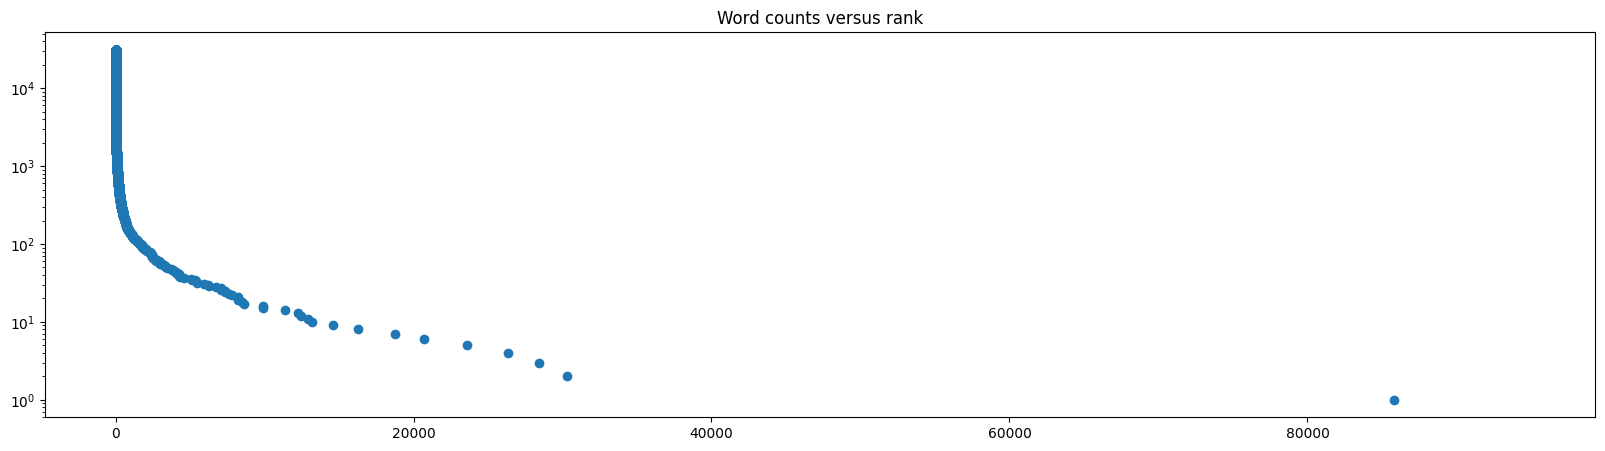

Vocabulary size: 31130
Part of the corpus by taking the "x" most frequent words:
1000 : 0.00
2000 : 0.00
3000 : 0.01
4000 : 0.02
5000 : 0.03
6000 : 0.04
7000 : 0.05
8000 : 0.07
9000 : 0.08
10000 : 0.10
11000 : 0.12
12000 : 0.15
13000 : 0.17
14000 : 0.20
15000 : 0.23
16000 : 0.26
17000 : 0.30
18000 : 0.33
19000 : 0.37
20000 : 0.41
21000 : 0.46
22000 : 0.50
23000 : 0.55
24000 : 0.59
25000 : 0.64
26000 : 0.70
27000 : 0.75
28000 : 0.81
29000 : 0.87
30000 : 0.93
31000 : 0.99


In [17]:
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts[:,0], rank_counts[:,1])
plt.yscale('log')
plt.show()

print('Vocabulary size: %i' % len(freq))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(1000, len(freq), 1000):
    print('%i : %.2f' % (i, np.sum(rank_counts[:i, 1]) / np.sum(rank_counts[:,1]) ))

del tokens
del freq
del ordered_word_list
del rank_counts

### Creating a model: a first, simple version

This model will take as input **a fixed number of characters** and output the next one. We will treat the model as a *black box* and leave its innner working for later.

#### Creating training data
- We will represent characters using *one-hot vectors*. Hence, the i-th character of n possible characters will be represented by a vector of length $n$, containing $0$ expect for a $1$ in position $i$. Following our previous examples, ```a = [1, 0, 0]``` and ```b = [0, 1, 0]```.
- Hence, a sequence of characters is a list of one-hot vectors. Our goal will be to predict, given an input sequence of fixed length (here, this length is given by ```maximum_seq_length```) the next character. Hence, we need to build two lists: ```sentences```, containing the input sequences, and ```next_char``` the characters to be predicted.
- We do not necessarily need to take all possible sequences. We can select one every ```time_step``` steps.

Example: Using the previous dictionnaries, the sequence:
```'acabbaccaabba'``` with ```maximum_seq_length = 4``` and ```time_step = 2``` would give the following lists:

```python
sentences = ['acab', 'abba', 'bacc', 'ccaa', 'aabb']
```

```python
next_char = ['b', 'c', 'a', 'b', 'a']
```

<div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
maximum_seq_length = 30
time_step = 4
sentences = []
sentences_next_char = []
for i in range(0, len(text)-maximum_seq_length, time_step):
    sentences.append(text[i:i+maximum_seq_length])
    sentences_next_char.append(text[i+maximum_seq_length])
print('Number of Sequences:', len(sentences))

Number of Sequences: 1325062


#### Creating training tensors
- We need to transform these lists into tensors, using one-hot vectors to represent characters.
- We will need 3 dimensions for the training examples from ```sentences```: the number of examples, the length of the sequence, and the dimension of the one-hot vector
- This is reduced to 2 dimensions for the ```next_char```: number of examples and one-hot vector.

Example: the previous ```sentences``` would become:

```python
X = [[[1, 0, 0],
      [0, 0, 1],
      [1, 0, 0],
      [0, 1, 0]],
     [[1, 0, 0],
      [0, 1, 0],
      [0, 1, 0],
      [1, 0, 0]],
     [[0, 1, 0],
      [1, 0, 0],
      [0, 0, 1],
      [0, 0, 1]],
     [[0, 0, 1],
      [0, 0, 1],
      [1, 0, 0],
      [1, 0, 0]],
     [[1, 0, 0],
      [1, 0, 0],
      [0, 1, 0],
      [0, 1, 0]]]
```
       
```python
y = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0],
     [0, 1, 0],
     [1, 0, 0]]
```

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
X = np.zeros((len(sentences), maximum_seq_length, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
# Loop over the sentences
for i, sentence in enumerate(sentences):
    # Loop over the characters
    for j in range(maximum_seq_length): ## Bound to maximum_seq_len
        # Put the right value of X to 1
        X[i,j,char_indices[sentence[j]]] = 1 ## sentence[j] is char j in sentence i
    # Put the right value of y to 1
    y[i, char_indices[sentences_next_char[i]]] = 1

#### Implement the model

In order to implement the model as simply as possible, we will use ```keras```. It allows to create models with only a few lines of code.
First, we will create a very simple model based on a **LSTM**, which is a *recurrent* architecture. Note that one the strength of a recurrent architecture is to allow for inputs of varying length - here, to simplify data processing, we will keep a **fixed input size**.

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Input
from keras.layers import LSTM
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.metrics import sparse_categorical_crossentropy, categorical_crossentropy

We need to create a LSTM model that takes directly out inputs from ```X``` and try to predict one-hot vectors from ```y```.
- What are the input and output dimensions ?
  - ```X```: size of the dataset $\times$ maximum sequence length $\times$ vocabulary size
  - ```y```: size of the dataset $\times$ vocabulary size
- The model should be made with a ```LSTM``` layer, and a ```Dense``` layer followed by a softmax activation function. Work out the intermediate dimensions:
  - ```X``` $\rightarrow$ (LSTM) $\rightarrow$ ```h``` $\rightarrow$ (Dense) $\rightarrow$ ```s``` $\rightarrow$ (softmax) $\rightarrow$ ```pred```
  - Look at layers arguments and find out to proper ```input_shape``` for the ```LSTM``` layer and the proper size for the ```Dense``` layer.
  - You can use 128 as the size of hidden states for the ```LSTM```.
- We will minimize ```cross-entropy(pred, y)```. Use the ```categorical_crossentropy``` loss, with the optimizer of your preference (for example, ```adam```).

In [ ]:
vocab_size = len(chars)
model = Sequential()
model.add(Input(shape=(maximum_seq_length, vocab_size, )))
model.add(LSTM(128,))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         101,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 70)                  │           9,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 70)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,918 (433.27 KB)

 Trainable params: 110,918 (433.27 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

You will now only need a few functions to use this model:
- ```model.fit```, which you will call on the appropriately processed data ```X, y```
- ```model.predict```, which you will use on an input **of the same dimension of X** to output the probabilities. That includes the *first one*, corresponding to the number of examples in the input.

### Create functions to generate text with our model
- We use the output of our model (vector of probabilities on characters) to select the next most probable character (with the ```argmax```)
- We need to transform an input text into an input tensor, as before (taking the right length, the last ```maximum_seq_length``` characters)
- We need to transform back the most probable index into a character and add it to our text.
- This must be looped ```num_generated``` times, each time obtaining a new input tensor from the new input sequence (which has the character we previously predicted at the end !)

We can begin to write a function facilitating the transfer between text and tensors:

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def get_tensor(sentence, voc):
    sentence = sentence[-maximum_seq_length:]
    x = np.zeros((maximum_seq_length, vocab_size)) ## Can be customize to voc size though
    # Fill out x appropriately
    for i,char in enumerate(sentence):
      x[i,char_indices[char]] = 1
    return x

You have now what is necessary to fill out ```generate_next```.

The following function (```end_epoch_generate```) is here to facilitate automatic generation at the end of each epoch, so you can monitor of generation changes as the model trains. It calls the ```generate_next``` function upon each sequence of text in ```texts_ex```. The only element in this list right now comes from the training data - you can add your own. We also use ```EarlyStopping``` to stop training when validation loss does not decrease.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def generate_next(model, text, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor(sentence, chars)
        predictions = model.predict(x[None,:,:])
        next_index = np.argmax(predictions)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

def end_epoch_generate(epoch, _):
    print(' Generating text after epoch: %d' % (epoch+1))
    texts_ex = ["From fairest creatures we desire increase,"]
    for text in texts_ex:
        sample = generate_next(model, text.lower())
        print('%s' % (sample))

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

Test generation with the model not yet trained:

In [ ]:
text_ex = "From fairest creatures we desire increase,"
generate_next(model, text_ex.lower())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

'from fairest creatures we desire increase,2\ufeffî]f”îàîddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd'

In [ ]:
import tensorflow as tf

In [ ]:
model.fit(X, y,
          batch_size=128,
          epochs=5,
          validation_split = 0.2,
          callbacks=[LambdaCallback(on_epoch_end=end_epoch_generate), early_stopping])

Epoch 1/5
8277/8282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3253 - loss: 2.3719 Generating text after epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━

#### Sampling with our model
- Now, instead of simply selecting the most probable next character, we would like to be able to draw a sample from the distribution output by the model.
- To better control the generation, we would like to use the argument ```temperature```, to smooth the distribution.
- Use the ```multinomial``` function from the ```random``` package to draw samples.
- Integrate this into a function ```generate_sample``` that be almost exactly like ```generate_next```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def sample(predictions, temperature, placeholder=None):
    # From the prediction, apply the temperature to reweights the probabilities and sample.
    log_predictions = np.log(predictions).astype('float64')
    softmax_denom = np.sum(np.exp(log_predictions/temperature))
    softmax_num = np.exp(log_predictions/temperature)
    probas = softmax_num/softmax_denom
    return np.argmax(np.random.multinomial(1, probas))

def generate_sample(model, text, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor(sentence, chars)
        predictions = model.predict(x[None,:,:])
        next_index = sample(predictions.flatten(), temperature)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_sample(model, text_ex.lower(), temperature = 0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

'from fairest creatures we desire increase, to give there to a to mither age in flood and in such so, are my life of with did altiants, i’ll be me beater. what i b'

#### Generate text with the beam algorithm
- Complete this function implementing the beam procedure.
- We need to loop for each character we want to generate, keeping track of the best ```beam_size``` sequences at the most.
- Besides keeping track of past generated character for each of these ```beam_size``` sequences, we need to keep track of their log-probability.
- This is done by, at each loop, keeping the ```beam_size```best predictions for each of the ```beam_size``` sequences, computing the log-probabilities of the newly formed (```beam_size```)$^2$ , and keeping the overall ```beam_size``` best new sequences.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def generate_beam(model, text, beam_size=5, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    # Initialization of the beam with log-probabilities for the sequence
    current_beam = [(0, [], sentence)]

    for l in range(num_generated):
        all_beams = []
        for prob, current_preds, current_input in current_beam:
            x = get_tensor(current_input, chars)
            predictions = model.predict(x[None,:,:])
            log_predictions = np.log(predictions).flatten()
            # beam_size best predictions !
            possible_next_chars = log_predictions.argsort()[-beam_size:]
            # Add to the beams: (the probability of the sequence, the sequence of indexes generated, the full sequence of characters)
            all_beams += [
                (prob + log_predictions[next_char],
                 current_preds + [next_char],
                 current_input[1:] + indices_char[next_char]
                )
                for next_char in possible_next_chars]

        # Sort the beams according to their probability and keep the beam_size best
        current_beam = sorted(all_beams, key=lambda x: x[0], reverse=True)[:beam_size]
        generated += indices_char[current_beam[0][1][-1]]
    return generated

In [ ]:
generate_beam(model, text_ex.lower())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'from fairest creatures we desire increase, and the    e th  ot sheh the r haad n e  i e  l not  heh the r haad n e  i e  l not  heh the r haad n e  i e  l not  he'

#### Generate text with top-k sampling
- This is very similar to the previously implemented sampling procedure, but we would like to choose a parameter ```k```, which is used to limit the sampling to the top-$k$ results of the model prediction.

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
def sample_top_k(predictions, temperature, k):
    log_predictions = np.log(predictions).astype('float64')
    indices_to_remove = predictions.argsort()[:-k]
    log_predictions[indices_to_remove] = -float('Inf')
    softmax_denom = np.sum(np.exp(log_predictions/temperature))
    softmax_num = np.exp(log_predictions/temperature)
    probas = softmax_num/softmax_denom
    return np.argmax(np.random.multinomial(1, probas))

def generate_top_k(model, text, k, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor(sentence, chars)
        predictions = model.predict(x[None,:,:])
        next_index = sample_top_k(predictions.flatten(), temperature, k)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_top_k(model, text_ex.lower(), k=5, num_generated=120, temperature = 0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

'from fairest creatures we desire increase, whom there are to shall helse with her wear to see, and i should have the wish a them to me. i have a man thee well in '

#### Generate text with top-p sampling
- This is very similar to the previously implemented sampling procedure, but we would like to choose a parameter ```p```, which is used to limit the sampling to the top results of the model prediction corresponding together to at least the probability $p < 1$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def sample_top_p(predictions, temperature, p):
    log_predictions = np.log(predictions).astype('float64')
    cum_prob = 0.0
    incr = 0
    # Get indices in increasing order of probability
    indices = predictions.argsort()
    probs = predictions[indices]
    # Increment cum_prob with until it gets above 1 - p
    # Keep track of the indices, which will be those to remove
    while cum_prob < 1 - p:
      cum_prob += probs[incr]
      incr += 1

    indices_to_remove = indices[0:incr-1]
    log_predictions[indices_to_remove] = -float('Inf')
    softmax_denom = np.sum(np.exp(log_predictions/temperature))
    softmax_num = np.exp(log_predictions/temperature)
    probas = softmax_num/softmax_denom
    return np.argmax(np.random.multinomial(1, probas))

def generate_top_p(model, text, p, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor(sentence, chars)
        predictions = model.predict(x[None,:,:])
        next_index = sample_top_p(predictions.flatten(), temperature, p)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_top_p(model, text_ex.lower(),  p=0.75, temperature = 0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'from fairest creatures we desire increase, and that thee, then for of mind out that i will better better me come and i see in more of the strained lear. second to'

#### Reranking
If we would like to use our outputs for a task, a common strategy is to generate a large number of them, and select the one that maximizes the relevant metric: this is **re-ranking**.

First, we need an evaluation measure. For now, we can use **perplexity**: given how cross-entropy is computed in ```keras```, perplexity is simply *the exponential of the mean cross-entropy over the sequence*.

To compute the cross-entropy, you need both the true ```y``` and the corresponding ```pred``` output by the model. While the most efficient would be to gather these while sampling, we can re-compute it for any sentence with the following function:

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def get_preds(sentence):
    # Reconstitute the inputs and outputs from the sentence: first as list of characters
    eval_input = []
    eval_target = []
    for i in range(0, len(sentence)-maximum_seq_length):
        eval_input.append(sentence[i:i+maximum_seq_length])
        eval_target.append(sentence[i+maximum_seq_length])

    # Then as tensors
    eval_X = np.zeros((len(eval_input), maximum_seq_length, len(chars)), dtype=bool)
    eval_y = np.zeros((len(eval_target), len(chars)), dtype=bool)
    for i, sentence in enumerate(eval_input):
        for j in range(maximum_seq_length):
          eval_X[i, j, char_indices[sentence[j]]] = 1
        y[i, char_indices[eval_target[i]]] = 1

    eval_pred = model.predict(eval_X)

    return eval_y, eval_pred

In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = categorical_crossentropy(y_true, y_pred)
    perplexity = np.exp(cross_entropy.numpy().mean())
    return perplexity

In [ ]:
def re_rank(sentence):
    eval_y, eval_pred = get_preds(sentence)
    return perplexity(eval_y, eval_pred)

You can then generate a bunch of sentences, obtain their perplexity and sort them accordingly:

In [ ]:
reranked = dict()
for k in np.arange(5,10):
    for t in np.arange(0.5, 1.0, 0.05):
        sentence = generate_top_k(model, text_ex.lower(), k, temperature = 0.7)
        p = re_rank(sentence)
        reranked[sentence] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
print(sorted(reranked, key=reranked.get))

In [ ]:
print(reranked)

If you use colab, the tensors are close to filling the memory available freely. You should delete them before moving on to the next model. By the way, what should we be doing to avoid this ?

Ans : Beside, deleting the tensors we can just reduce the batch size which will limit the amount of memory we use at once.

In [ ]:
del X
del y
#del model

### Create a second model: with embeddings

This model will have a key difference with the previous one: we will use **dense embeddings** instead of one-hot representations.
This means that:
- In ```X```, we will use the index of the character instead of an one-hot vector. For example, the following ```['acab', 'abba', 'bacc', 'ccaa', 'aabb']``` will be represented as ```[[0, 2, 0, 1], [0, 1, 1, 0], [1, 0, 2, 2], [2, 2, 0, 0]]```.
- We will need another input layer before the LSTM. Instead of ```Dense```, keras has a dedicated layer: ```Embedding```.

Create the dataset, adapt the generation function, create the new model, and compare the results.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
X_emb = np.zeros((len(sentences), maximum_seq_length))
y_emb = np.zeros((len(sentences), vocab_size))
for i, sentence in enumerate(sentences):
    for j in range(maximum_seq_length):
        X_emb[i,j] = char_indices[sentence[j]]
    y_emb[i, char_indices[sentences_next_char[i]]] = 1

print('X_emb shape:', X_emb.shape)
print('y_emb shape:', y_emb.shape)

X_emb shape: (1325062, 30)
y_emb shape: (1325062, 70)


In [ ]:
from keras.layers import Embedding

In [ ]:
def generate_next_emb(model, text, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor_emb(sentence, maximum_seq_length, chars)
        predictions = model.predict(x[None,:])
        next_index = np.argmax(predictions)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

def end_epoch_generate(epoch, _):
    print('\n Generating text after epoch: %d' % (epoch+1))
    texts_ex = ["From fairest creatures we desire increase,"]
    for text in texts_ex:
        sample = generate_next_emb(model_emb_m2m, text)
        print('%s' % (sample))

In [ ]:
def get_tensor_emb(sentence, maximum_seq_length, voc):
    sentence = sentence[-maximum_seq_length:]
    x = np.zeros((maximum_seq_length)) ## Can be customize to voc size though
    # Fill out x appropriately
    for i,char in enumerate(sentence):
      x[i] = char_indices[char]
    return x

Depending on how you create ```y```, you might need to change the loss. Indeed, ```categorical_crossentropy``` is made for **one-hot encoded output**  ! If you encoded ```y``` using the character indexes, like ```X```, you can use ```sparse_categorical_crossentropy```.

In [ ]:
#Define the model
from tensorflow.keras import backend as K

K.clear_session()
model_emb_m2m = Sequential()
model_emb_m2m.add(Input(shape=(maximum_seq_length,)))
model_emb_m2m.add(Embedding(vocab_size, 32))
model_emb_m2m.add(LSTM(128,))
model_emb_m2m.add(Dense(vocab_size,))
model_emb_m2m.add(Activation('softmax'))
print(model_emb_m2m.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 32)              │           2,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 70)                  │           9,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 70)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,702 (366.02 KB)

 Trainable params: 93,702 (366.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_emb_m2m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_emb_m2m.fit(X_emb, y_emb,
                  batch_size=128,
                  epochs=5,
                  validation_split = 0.2,
                  callbacks=[LambdaCallback(on_epoch_end=end_epoch_generate)])

Epoch 1/5
8276/8282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3388 - loss: 2.3010
 Generating text after epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━

In [ ]:
generate_next_emb(model_emb_m2m, "From fairest creatures we desire increase,")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

'From fairest creatures we desire increase, and the serving the serving the serving the serving the serving the serving the serving the serving the serving the ser'

In [ ]:
def generate_sample_emb(model, text, k, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor_emb(sentence, maximum_seq_length, chars)
        predictions = model.predict(x[None,:])
        next_index = sample_top_k(predictions.flatten(), temperature, k)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
text_ex = "From fairest creatures we desire increase,"

In [ ]:
generate_sample_emb(model_emb_m2m, text_ex.lower(), 5, temperature = 0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'from fairest creatures we desire increase, i am is all see a prince. i have see a might have is the part to be so and with the palace the part of the parting the '

In [ ]:
del X_emb
del y_emb
del model_emb_m2m

### Create a third model: with stateful LSTMs

By default, ```LSTM``` layers in Keras have the argument ```stateful=False```, which means that **hidden states are not kept from a sample to another**. For this last model, we can investigate a *stateful* model, which implies that sequences are *in effect* not of fixed size, as information is transmitted from one example to the next.

- We need to retain information from one example to the other. Working like this, which hyperparameter do we need to change for the ```X``` and ```y``` tensors to make sense ?

Ans : We should change the batch size which is by default dynamic to a fix size. Hence our training sample should be an integer multiple of the batch size.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
batch_size = 128
num_batches = len(sentences) // batch_size  # Number of complete batches

X_emb = np.zeros((num_batches * batch_size, maximum_seq_length))  # Shape: (number of examples, max_seq_length)
y_emb = np.zeros((num_batches * batch_size, vocab_size))  # Shape: (number of examples, vocab_size)

for batch in range(num_batches):
    for i in range(batch_size):
        # Calculate the index for the current sentence
        sentence_idx = batch * batch_size + i
        sentence = sentences[sentence_idx]

        # Fill the input array X_emb with character indices
        for j in range(min(maximum_seq_length, len(sentence))):  # Handle shorter sentences
            X_emb[batch * batch_size + i, j] = char_indices[sentence[j]]

        # Set the label for the next character after the sentence
        if sentence_idx < len(sentences_next_char):
            next_char_index = char_indices[sentences_next_char[sentence_idx]]  # Next char for the full sentence
            # One-hot encode the label in y_emb
            y_emb[batch * batch_size + i, next_char_index] = 1

# Print the shapes to confirm
print('X_emb shape:', X_emb.shape)
print('y_emb shape:', y_emb.shape)


X_emb shape: (1325056, 30)
y_emb shape: (1325056, 70)


One constraint of *stateful* models is that they require a **static batch size** while it can be dynamic by default.

- This implies that the first dimension of ```X``` and ```y``` are **exactly divided** by the batch size. Remove the few examples that are over that limit !
- This implies that the batch size is given at model creation, in the ```Input``` layer, through the argument ```batch_size```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
batch_size = 128

In [ ]:
# Keep a size that is exactly divided by the batch_size for both X and y
## Note : This is already done above
X_emb = ...
y_emb = ...

In [ ]:
model_emb_m2m = Sequential()
model_emb_m2m.add(Input(batch_shape=(batch_size, maximum_seq_length)))
model_emb_m2m.add(Embedding(input_dim=vocab_size, output_dim=32))
model_emb_m2m.add(LSTM(128, stateful=True))
model_emb_m2m.add(Dense(vocab_size))
model_emb_m2m.add(Activation('softmax'))
print(model_emb_m2m.summary())

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (128, 30, 32)               │           2,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (128, 128)                  │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (128, 70)                   │           9,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (128, 70)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,702 (366.02 KB)

 Trainable params: 93,702 (366.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model_emb_m2m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Experimenting with *stateful* models is difficult because of the static ```batch_size```: the function ```predict``` must be used with the same batch size !

- A simple way to avoid this is to build another instance of the same model with a static ```batch_size=1``` and to copy the weights of the one we trained.

- We also need to **reset** the hidden states each time we change sequence, with the method ```reset_states()``` called on the ```LSTM``` layer. For us, it will be at each epoch.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def get_tensor_emb(sentence, maximum_seq_length, voc):
    sentence = sentence[-maximum_seq_length:]
    x = np.zeros((batch_size,maximum_seq_length)) ## Can be customize to voc size though
    # Fill out x appropriately
    for i,char in enumerate(sentence):
      x[0,i] = char_indices[char]
    return x

In [ ]:
def generate_next_emb(model, text, num_generated=120):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor_emb(sentence, maximum_seq_length, chars)
        predictions = model.predict(x, batch_size=batch_size)
        next_index = np.argmax(predictions[0])
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

def create_copy(model_c):
    # Define the model exactly as above
    # Without the compilation
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, maximum_seq_length,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32))
    model.add(LSTM(128, stateful=True))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.set_weights(model_c.get_weights())
    return model

def end_epoch_generate(epoch, _):
    print('\n Generating text after epoch: %d' % (epoch+1))
    texts_ex = ["From fairest creatures we desire increase,"]
    # Reset the states at the end of the epoch
    model_emb_m2m.layers[1].reset_states()
    # Create a copy of the model
    model_instance = create_copy(model_emb_m2m)
    for text in texts_ex:
        model_instance.layers[1].reset_states()
        # Generate the text
        sample = generate_next_emb(model_instance, text)
        print('%s' % (sample))
    # Delete the copy
    del model_instance

In [ ]:
# Keep using the same batch_size
# Should we shuffle the data here ?
model_emb_m2m.fit(X_emb, y_emb,
                  batch_size=batch_size,
                  epochs=4,
                  shuffle=True,
                  callbacks=[LambdaCallback(on_epoch_end=end_epoch_generate)])

Epoch 1/4
10352/10352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4693 - loss: 1.7690
 Generating text after epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 

In [ ]:
def generate_sample_emb(model, text, k, num_generated=120, temperature=1.0):
    generated = text
    sentence = text[-maximum_seq_length:]
    for i in range(num_generated):
        # Obtain the representation for the sentence, the prediction, the index of the better character and the character itself.
        x = get_tensor_emb(sentence, maximum_seq_length, chars)
        predictions = model.predict(x, batch_size=batch_size)
        next_index = sample_top_k(predictions[0].flatten(), temperature, k) ## Ignore all the rows except the first cause all others are fillers
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    return(generated)

In [ ]:
generate_sample_emb(model_emb_m2m, text_ex.lower(), 5, temperature = 0.7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

'from fairest creatures we desire increase, and the fates. i would bear he will not as that the son the would nor shours thou art to the crownest of the watch the '

In [ ]:
del X_emb
del y_emb
del model_emb_m2m

**Remark**: in theory, the model would have access to the same quantity of information whatever the size of ```maximum_seq_length``` is. However, the stateless recurrence seems to be working quite better. We will work with ```pytorch``` for the next lab implicating text generation.

### Using a pre-trained model via HuggingFace

The [Reformer Language model](https://metatext.io/models/google-reformer-enwik8) is one of the rare available character level model, and trained on enwik8.

```reformer-enwik8``` was pretrained on the first 90M chars of enwik8 whereas the text was chunked into batches of size 65536 chars (=2^16). The model's weights were taken from https://console.cloud.google.com/storage/browser/trax-ml/reformer/enwik8 and converted to Hugging Face's PyTorch ```ReformerModelWithLMHead```.

To work with the model, you can use the generic wrappers which are given in example in the first link above. However, the model normally does not need a tokenizer, and can work with encoding and decoding functions similar in spirit with what we did before.

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- Ignoring ```attention_masks```, try to understand:
  - How are the input built ? It's a sequence of characters from Wikipedia text corpus
  
  - What is the vocabulary here ? The vocabulary is hence a set of all unique character (punctuations and alphanum) appearing in english Wikipedia

In [15]:
import torch

# Encoding
def encode(list_of_strings, pad_token_id=0):
    max_length = max([len(string) for string in list_of_strings])

    # create emtpy tensors
    attention_masks = torch.zeros((len(list_of_strings), max_length), dtype=torch.long)
    input_ids = torch.full((len(list_of_strings), max_length), pad_token_id, dtype=torch.long)

    for idx, string in enumerate(list_of_strings):
        # make sure string is in byte format
        if not isinstance(string, bytes):
            string = str.encode(string)

        encoded_string = torch.tensor([x + 2 for x in string], dtype=torch.long)  # Add 2 to each character byte
        length_to_fill = min(encoded_string.size(0), max_length)
        input_ids[idx, :length_to_fill] = encoded_string[:length_to_fill]
        attention_masks[idx, :length_to_fill] = 1

    return input_ids, attention_masks

# Decoding
def decode(outputs_ids):
    decoded_outputs = []
    for output_ids in outputs_ids.tolist():
        # transform id back to char IDs < 2 are simply transformed to ""
        decoded_outputs.append("".join([chr(x - 2) if x > 1 else "" for x in output_ids]))
    return decoded_outputs

- Try to generate from the same verse than before.
  - Interpret what is generated. Why do you think the result is so different than what we obtained before ?

  We didn't trained the model with the same corpus and since there is no domain adaptation or fine-tuning, the output will obviously be different. The conditional distributions of tokens are not the same
  
  
<div class='alert alert-block alert-info'>
          Code:</div>

In [28]:
from transformers import ReformerModelWithLMHead, ReformerConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ReformerModelWithLMHead.from_pretrained("google/reformer-enwik8")
model.to(device)

text_ex = ["From fairest creatures we desire increase,"]

input_text = text_ex
input_ids, attention_mask = encode(input_text)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    # Generate text of length up to max_seq_length
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=120,
        do_sample=True,  # Use sampling for text generation
        num_return_sequences=1,  # Return only one generated sequence
        pad_token_id=0  # Make sure padding is set properly
    )

outputs = outputs.cpu()
generated_text = decode(outputs)

# Print the result
print(f"Input: {input_text[0]}")
print(f"Generated Text: {generated_text[0]}")


Input: From fairest creatures we desire increase,
Generated Text: From fairest creatures we desire increase, and we identify them with regular holiday variety.&quot; However, since faire
